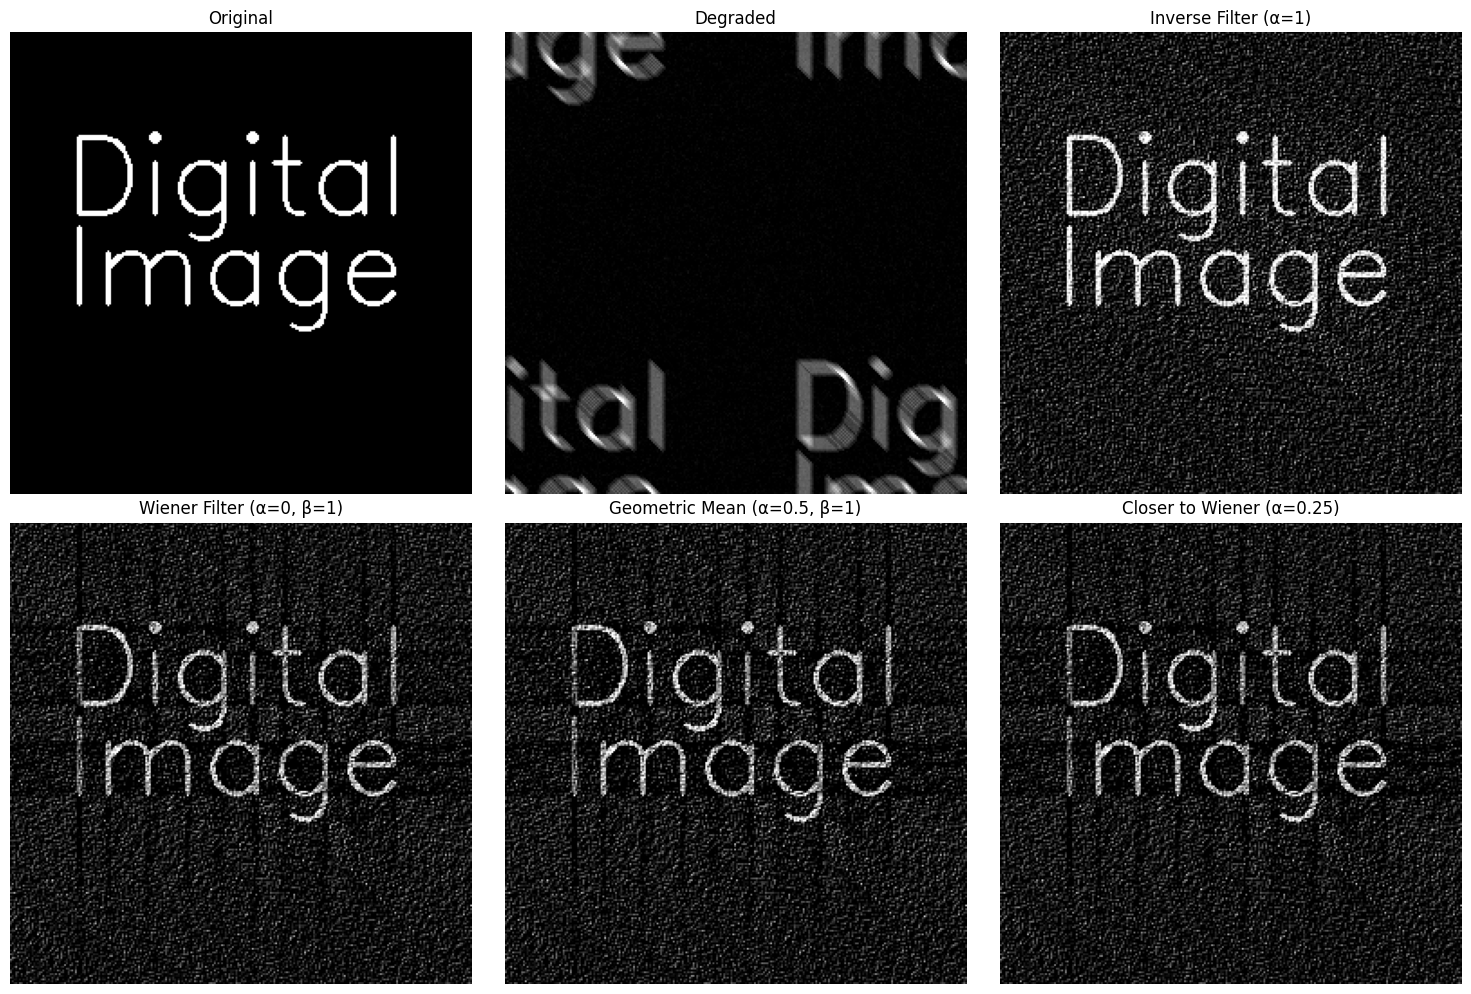

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def create_motion_psf(shape, angle=45, motion_dist=15):
    """Create motion blur PSF."""
    psf = np.zeros(shape)
    center = (shape[0]//2, shape[1]//2)

    angle_rad = np.deg2rad(angle)
    dx = motion_dist * np.cos(angle_rad)
    dy = motion_dist * np.sin(angle_rad)

    cv2.line(psf,
             (int(center[1] - dx/2), int(center[0] - dy/2)),
             (int(center[1] + dx/2), int(center[0] + dy/2)),
             1, 1, cv2.LINE_AA)

    return psf / psf.sum()

def estimate_spectra(degraded_image, psf, noise_std):
    """
    Improved power spectra estimation.
    """
    # Estimate noise power spectrum
    Sn = noise_std**2

    # Estimate signal power spectrum using Wiener-like approach
    G = np.fft.fft2(degraded_image)
    H = np.fft.fft2(psf, s=degraded_image.shape)
    H_mag_squared = np.abs(H)**2

    # Use smoothed periodogram for signal spectrum
    window = np.hanning(degraded_image.shape[0])[:, None] * np.hanning(degraded_image.shape[1])[None, :]
    smoothed_periodogram = np.abs(G)**2 * window

    # Estimate original signal spectrum
    Sf = smoothed_periodogram / (H_mag_squared + 1e-10)
    Sf = np.maximum(Sf, 1e-10)  # Ensure positivity

    return Sn, Sf

def geometric_mean_filter(degraded, psf, alpha=0.5, beta=1.0, noise_std=15):
    """
    Improved geometric mean filter implementation.
    """
    # Convert to frequency domain
    G = np.fft.fft2(degraded.astype(float))
    H = np.fft.fft2(psf, s=degraded.shape)

    # Get power spectra
    Sn, Sf = estimate_spectra(degraded, psf, noise_std)

    # Calculate filter components with improved numerical stability
    H_conj = np.conjugate(H)
    H_mag_squared = np.abs(H)**2
    eps = 1e-10  # Small constant for numerical stability

    # First term (inverse filter component)
    term1 = np.power(H_conj / (H_mag_squared + eps), alpha)

    # Second term (Wiener-like component)
    wiener_denominator = H_mag_squared + beta * (Sn/Sf)
    term2 = np.power(H_conj / (wiener_denominator + eps), 1-alpha)

    # Apply filter
    F = term1 * term2 * G

    # Transform back to spatial domain
    restored = np.real(np.fft.ifft2(F))

    return np.clip(restored, 0, 255).astype(np.uint8)

def apply_degradation(image, psf, noise_std):
    """Apply motion blur and add noise with better control."""
    # Ensure float computation
    img_float = image.astype(float)

    # Apply motion blur in frequency domain
    F = np.fft.fft2(img_float)
    H = np.fft.fft2(psf, s=image.shape)
    blurred = np.real(np.fft.ifft2(F * H))

    # Add noise
    noise = np.random.normal(0, noise_std, image.shape)
    degraded = blurred + noise

    return np.clip(degraded, 0, 255).astype(np.uint8)

def demonstrate_geometric_mean_filter(image_size=(256, 256)):
    """Demonstrate geometric mean filter with improved parameters."""
    # Create test image
    image = np.zeros(image_size, dtype=np.uint8)
    cv2.putText(image, 'Digital', (30, 100), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)
    cv2.putText(image, 'Image', (30, 150), cv2.FONT_HERSHEY_SIMPLEX, 2, 255, 2)

    # Create PSF and degrade image
    psf = create_motion_psf(image_size, angle=45, motion_dist=10)  # Reduced motion distance
    noise_std = 5  # Reduced noise level
    degraded = apply_degradation(image, psf, noise_std)

    # Test different parameter combinations
    params = [
        (1.0, 1.0, "Inverse Filter (α=1)"),
        (0.0, 1.0, "Wiener Filter (α=0, β=1)"),
        (0.5, 1.0, "Geometric Mean (α=0.5, β=1)"),
        (0.25, 1.0, "Closer to Wiener (α=0.25)")
    ]

    plt.figure(figsize=(15, 10))

    # Plot original
    plt.subplot(231)
    plt.imshow(image, cmap='gray')
    plt.title('Original')
    plt.axis('off')

    # Plot degraded
    plt.subplot(232)
    plt.imshow(degraded, cmap='gray')
    plt.title('Degraded')
    plt.axis('off')

    # Plot restored images
    for i, (alpha, beta, title) in enumerate(params):
        restored = geometric_mean_filter(degraded, psf, alpha, beta, noise_std)
        plt.subplot(2, 3, i+3)
        plt.imshow(restored, cmap='gray')
        plt.title(title)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def main():
    demonstrate_geometric_mean_filter()

if __name__ == "__main__":
    main()